# Конспект по задаче линейной регрессии

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 1. Генерация датасета

Сгенерируем выборку $X$, в виде матрицы

In [43]:
# Детерминируем случайность, чтобы у всех все было одинаково
SEED = 21
np.random.seed(SEED)

# Параметры синтетики
n = 1200
d = 3

# Генерация фичей и инициализация вектора весов и сдвига (bias)
X = np.random.randn(n, d) # Генерируем X ~ N(0,1)
true_w = np.array([1.5, -2.0, 0.7])  # вектор весов
true_b = 0.5 # bias

# Сгенерируем таргет вектор с некоторым шумом
noise_sigma = 0.8
y = X.dot(true_w) + true_b + np.random.randn(n) * noise_sigma

# Деление на Test/Train = 20/80
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((960, 3), (240, 3), (960,), (240,))

`StandardScaler` из `sklearn.preprocessing` приводит признаки к стандартному виду:

$$
x^{\text{scaled}} = \frac{x - \mu}{\sigma}
$$

где

* $\mu$ — среднее значение признака,
* $\sigma$ — стандартное отклонение признака.

То есть после применения `StandardScaler`:

* каждый признак имеет среднее $0$;
* дисперсия каждого признака равна $1$.

**Зачем это нужно?**

1. **Ускоряет обучение** — градиентный спуск работает стабильнее, шаги более сбалансированы.
2. **Предотвращает доминирование признаков** — если один признак измеряется в километрах, а другой в миллиметрах, без масштабирования километровый «перекричит» остальные.
3. **Нормализация важна для регуляризации** (например, L1/L2 в линейных моделях), чтобы штрафы одинаково применялись к весам.


In [44]:
# Стандартизация признаков (важно для GD/SGD)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [45]:
# Вспомогательная функция для добавления колонки единиц. (Заносим биас в матрицу фич)
def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

print(X_train_s[:5])
print(add_bias(X_train_s[:5]))

[[-0.35144981 -0.02031681 -0.25438841]
 [ 0.33921562 -0.67748529 -0.04812012]
 [-0.01975693  0.60210455 -1.27263304]
 [-1.62438888  0.53970399 -0.48586879]
 [-0.48943133 -1.30586274  1.21849368]]
[[ 1.         -0.35144981 -0.02031681 -0.25438841]
 [ 1.          0.33921562 -0.67748529 -0.04812012]
 [ 1.         -0.01975693  0.60210455 -1.27263304]
 [ 1.         -1.62438888  0.53970399 -0.48586879]
 [ 1.         -0.48943133 -1.30586274  1.21849368]]


## 2. Создание метрик оценивания моделей

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def metrics_dict(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

## 3. Аналитическое решение. NumPy и sclearn

Минимизация ошибки по методу наименьших квадратов дает решение: $$ w = (X^TX)^{-1}X^TY $$

In [47]:
Xtr_b = add_bias(X_train_s)
Xte_b = add_bias(X_test_s)

# нормальное уравнение
weights_b = np.linalg.inv(Xtr_b.T.dot(Xtr_b)).dot(Xtr_b.T).dot(y_train)
b = weights_b[0]
w = weights_b[1:]

y_pred_analytic_numpy = Xte_b.dot(weights_b)
metrics_analytic_numpy = metrics_dict(y_test, y_pred_analytic_numpy)
metrics_analytic_numpy

{'MSE': 0.7262307289477464,
 'RMSE': np.float64(0.8521917207693034),
 'MAE': 0.6962384304245662,
 'R2': 0.9123171527860705}

sklearn: LinearRegression (аналитика внутри)

`LinearRegression` из библиотеки `scikit-learn` - это один из наиболее распространенных (готовых) алгоритмов для решения задач линейной регрессии.

**Основные параметры**

1. **fit_intercept** (по умолчанию True):
   - Этот параметр определяет, следует ли вычислять смещение (пересечение) при обучении модели. Если `True`, то модель будет учитывать это значение; если `False`, то она будет проходить через начало координат (0,0).

2. **normalize** (по умолчанию False):
   - Если `True`, то данные будут нормализованы перед применением линейной регрессии, что может быть полезно в некоторых случаях. Однако, начиная с версии 0.24, этот параметр устарел, и рекомендуется предварительно нормализовать данные с использованием `StandardScaler` или другого метода.

3. **copy_X** (по умолчанию True):
   - Если `True`, данные входного массива X будут скопированы перед обучением модели. Если `False`, то изменения могут быть внесены непосредственно в X.

4. **n_jobs** (по умолчанию None):
   - Параметр, который позволяет задать количество потоков для выполнения вычислений. Если `-1`, используется все доступные ядра процессора.

**Как хранятся веса модели**

После обучения модели `LinearRegression` веса модели хранятся в атрибуте `coef_`, а свободный член (смещение) — в атрибуте `intercept_`.

- **coef_**:
  - Это массив, который содержит коэффициенты (веса) для каждой из входных переменных. Для решения задачи с k признаками размерность этого массива будет (k,).

- **intercept_**:
  - Это скалярное значение, представляющее собой смещение модели; он добавляется к линейной комбинации входных признаков.

In [48]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)
metrics_lr = metrics_dict(y_test, y_pred_lr)
metrics_lr

{'MSE': 0.7262307289477464,
 'RMSE': np.float64(0.8521917207693034),
 'MAE': 0.6962384304245663,
 'R2': 0.9123171527860705}

Соберём метрики в таблицу и посмотрим результаты аналитических реализаций

In [49]:
metrics_table = pd.DataFrame([
    {**{'method': 'analytic_numpy'}, **metrics_analytic_numpy},
    {**{'method': 'sklearn_lr'}, **metrics_lr}
])

metrics_table

,method,MSE,RMSE,MAE,R2
0,analytic_numpy,0.726231,0.852192,0.696238,0.912317
1,sklearn_lr,0.726231,0.852192,0.696238,0.912317


## 4. Градиентный спуск

Реализуем: sklearn, numpy, pytorch

#### 4.1 NumPy: Batch Gradient Descent (MSE)

In [65]:
def batch_gradient_descent(X, y, lr=0.1, n_iters=1000, verbose=False):
    # X with bias
    n, d = X.shape
    theta = np.zeros(d)
    loss_history = []
    for it in range(n_iters):
        pred = X.dot(theta)
        err = pred - y
        loss = (err**2).mean()
        grad = (2.0/n) * X.T.dot(err)
        theta = theta - lr * grad
        loss_history.append(loss)
        if verbose and it % (n_iters//5) == 0:
            print(f"iter {it}, loss {loss:.4f}")
    return theta, loss_history

Xtr_b = add_bias(X_train_s)
theta_gd, loss_hist = batch_gradient_descent(Xtr_b, y_train, lr=0.1, n_iters=2000)

y_pred_gd = Xte_b.dot(theta_gd)
metrics_gd_numpy = metrics_dict(y_test, y_pred_gd)

metrics_gd_numpy

{'MSE': 0.7262307289477464,
 'RMSE': np.float64(0.8521917207693034),
 'MAE': 0.6962384304245662,
 'R2': 0.9123171527860705}

#### 4.2 sklearn: SGDRegressor (имитируем batch, но sklearn реализует SGD; установим learning_rate='constant' и большой max_iter)

In [66]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(max_iter=5000, tol=1e-8, penalty=None, eta0=0.1, learning_rate='constant', random_state=SEED)
# sklearn ожидает нецентрализованные X — у нас уже стандартизовано
sgd.fit(X_train_s, y_train)

y_pred_sgd_skl = sgd.predict(X_test_s)
metrics_sgd_skl = metrics_dict(y_test, y_pred_sgd_skl)

metrics_sgd_skl

{'MSE': 0.9483321796065226,
 'RMSE': np.float64(0.9738234848300398),
 'MAE': 0.7803856074445484,
 'R2': 0.8855013120513736}

#### 4.3 PyTorch: оптимизация методом стохастического градиента с батчем = весь train (т.е. batch GD)

In [64]:
import torch
import torch.nn as nn

torch.manual_seed(SEED) # Инициализация, чтоб сделать сравнимо

Xtr_t = torch.tensor(X_train_s, dtype=torch.float32)
Xte_t = torch.tensor(X_test_s, dtype=torch.float32)
ytr_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
yte_t = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

model = nn.Linear(d, 1) # автоматически включает bias

with torch.no_grad():
    model.weight.fill_(0.0)
    model.bias.fill_(0.0)

lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

n_epochs = 2000
loss_hist_pt = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(Xtr_t)
    loss = loss_fn(outputs.view(-1), ytr_t.view(-1))
    loss.backward()
    optimizer.step()
    loss_hist_pt.append(loss.item())

with torch.no_grad():
    y_pred_pt_gd = model(Xte_t).view(-1).numpy()
    metrics_pt_gd = metrics_dict(y_test, y_pred_pt_gd)

metrics_pt_gd

{'MSE': 0.7262307025671741,
 'RMSE': np.float64(0.8521917052912298),
 'MAE': 0.6962384065695884,
 'R2': 0.912317155971179}

Сравним метрики

In [53]:
metrics_table = pd.DataFrame([
    {'method': 'gd_numpy_batch', **metrics_gd_numpy},
    {'method': 'sgd_sklearn (really SGD)', **metrics_sgd_skl},
    {'method': 'pytorch_batch_gd', **metrics_pt_gd}
])
metrics_table

,method,MSE,RMSE,MAE,R2
0,gd_numpy_batch,0.726231,0.852192,0.696238,0.912317
1,sgd_sklearn (really SGD),0.948332,0.973823,0.780386,0.885501
2,pytorch_batch_gd,0.726231,0.852192,0.696238,0.912317


Построим графики потерь для NumPy и PyTorch

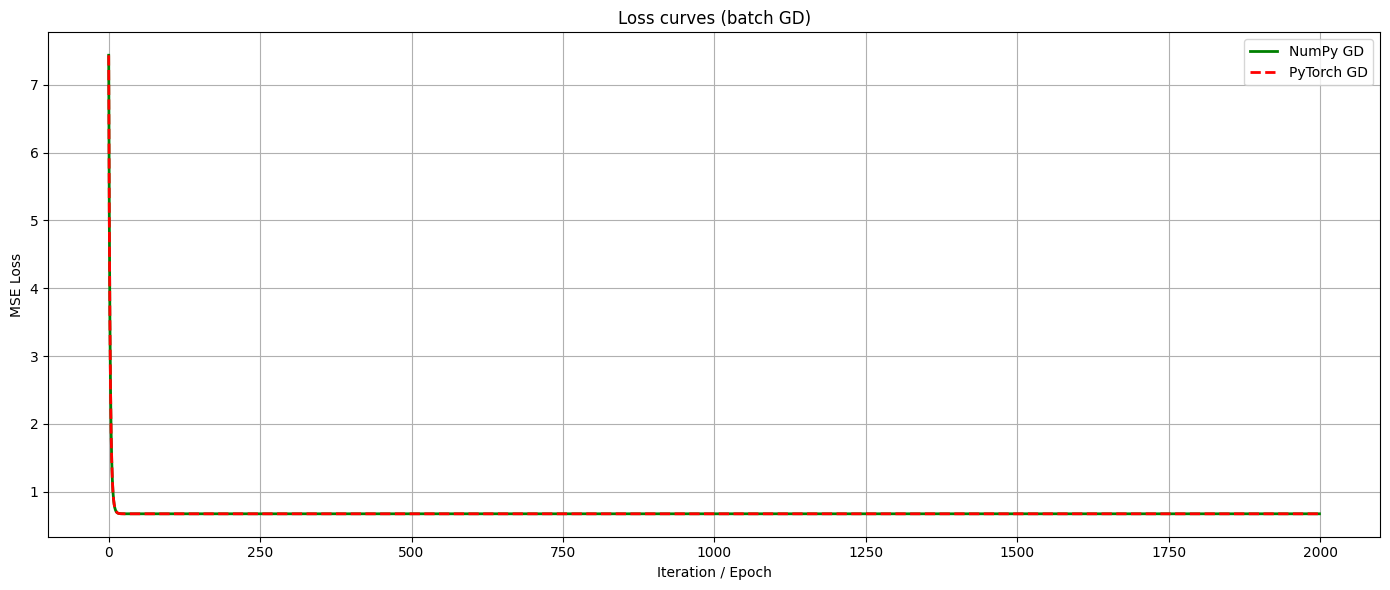

In [61]:
plt.figure(figsize=(14,6))
plt.plot(loss_hist, label='NumPy GD', color='green', linestyle='-', linewidth=2)
plt.plot(loss_hist_pt, label='PyTorch GD', color='red', linestyle='--', linewidth=2)
plt.xlabel('Iteration / Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss curves (batch GD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.4 Стохастический градиентный спуск (SGD)

In [63]:
def vanilla_sgd(X, y, lr=0.01, n_epochs=10, shuffle=True):
    n, d = X.shape
    theta = np.zeros(d)
    losses = []
    for epoch in range(n_epochs):
        idx = np.arange(n)
        if shuffle:
            np.random.shuffle(idx)
        for i in idx:
            xi = X[i:i+1]
            yi = y[i]
            pred = xi.dot(theta)[0]
            err = pred - yi
            grad = 2.0 * xi.T.flatten() * err
            theta = theta - lr * grad
            losses.append((err**2))
    return theta, losses

theta_sgd, losses_sgd = vanilla_sgd(Xtr_b, y_train, lr=0.01, n_epochs=40)
y_pred_sgd_numpy = Xte_b.dot(theta_sgd)
metrics_sgd_numpy = metrics_dict(y_test, y_pred_sgd_numpy)

metrics_sgd_numpy

{'MSE': 0.7356848342596017,
 'RMSE': np.float64(0.8577207204327069),
 'MAE': 0.6948577919727987,
 'R2': 0.9111756934143294}

sklearn: SGDRegressor (стандартный способ)

In [67]:
sgd_skl = SGDRegressor(max_iter=1000, tol=1e-6, penalty=None, eta0=0.01, learning_rate='constant', random_state=SEED)
sgd_skl.fit(X_train_s, y_train)
y_pred_sgd_skl2 = sgd_skl.predict(X_test_s)
metrics_sgd_skl2 = metrics_dict(y_test, y_pred_sgd_skl2)

metrics_sgd_skl2

{'MSE': 0.7405354684558094,
 'RMSE': np.float64(0.8605437051398432),
 'MAE': 0.6979625177182821,
 'R2': 0.9105900428763343}

PyTorch: DataLoader с маленьким batch (стохастический)

In [68]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8
train_ds = TensorDataset(Xtr_t, ytr_t)
loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model_sgd = nn.Linear(d, 1)
torch.manual_seed(SEED)
with torch.no_grad():
    model_sgd.weight.fill_(0.0)
    model_sgd.bias.fill_(0.0)

opt = torch.optim.SGD(model_sgd.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses_pt_sgd = []
for epoch in range(40):
    for xb, yb in loader:
        opt.zero_grad()
        out = model_sgd(xb).view(-1)
        loss = loss_fn(out, yb.view(-1))
        loss.backward()
        opt.step()
        losses_pt_sgd.append(loss.item())

with torch.no_grad():
    y_pred_pt_sgd = model_sgd(Xte_t).view(-1).numpy()
    metrics_pt_sgd = metrics_dict(y_test, y_pred_pt_sgd)

metrics_pt_sgd

{'MSE': 0.7263318000007418,
 'RMSE': np.float64(0.8522510193603419),
 'MAE': 0.6958274845586029,
 'R2': 0.9123049497804081}

In [70]:
metrics_table_sgd = pd.DataFrame([
    {'method': 'sgd_numpy_single_sample', **metrics_sgd_numpy},
    {'method': 'sgd_sklearn', **metrics_sgd_skl2},
    {'method': 'pytorch_sgd', **metrics_pt_sgd}
])

metrics_table_sgd

,method,MSE,RMSE,MAE,R2
0,sgd_numpy_single_sample,0.735685,0.857721,0.694858,0.911176
1,sgd_sklearn,0.740535,0.860544,0.697963,0.910590
2,pytorch_sgd,0.726332,0.852251,0.695827,0.912305


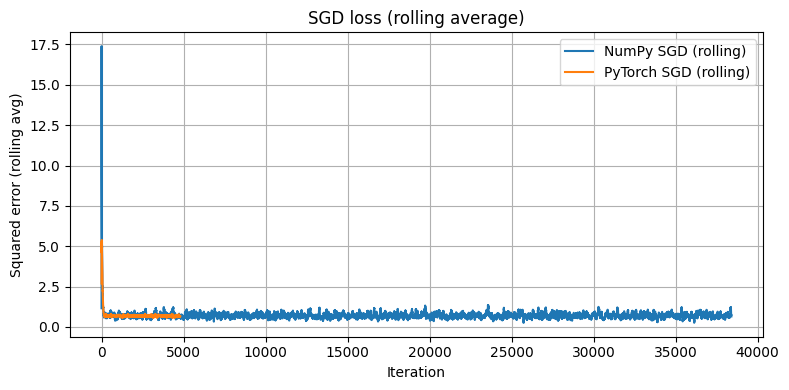

In [71]:
plt.figure(figsize=(8,4))
plt.plot(pd.Series(losses_sgd).rolling(50, min_periods=1).mean(), label='NumPy SGD (rolling)')
plt.plot(pd.Series(losses_pt_sgd).rolling(50, min_periods=1).mean(), label='PyTorch SGD (rolling)')
plt.xlabel('Iteration')
plt.ylabel('Squared error (rolling avg)')
plt.title('SGD loss (rolling average)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 5. Визуализация предсказаний (scatter + линии предсказаний для 1D / проекции)
Поскольку у нас d=3, для визуализации мы покажем:

- фактические y vs predicted y (диаграмма разброса)
- по одной координате (первый признак) — scatter и линия предсказаний при фиксировании остальных средними



y_true vs y_pred для нескольких методов

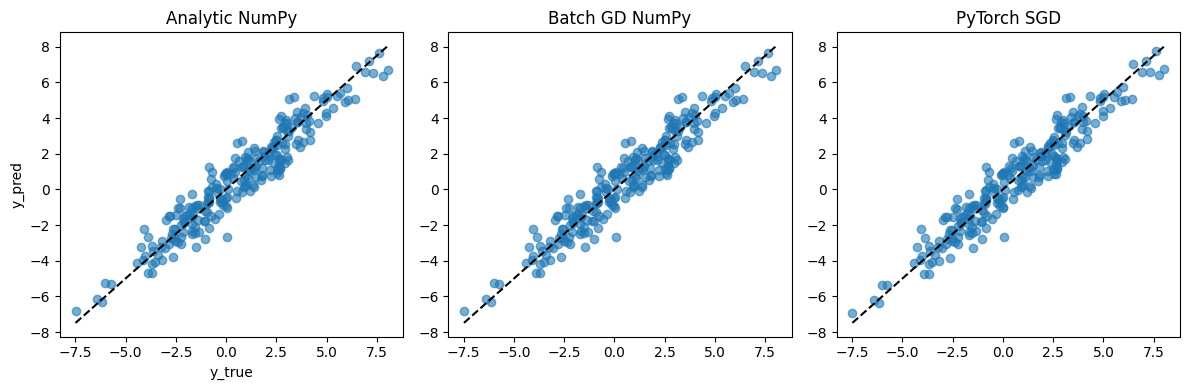

In [72]:

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(y_test, y_pred_analytic_numpy, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('Analytic NumPy')
plt.xlabel('y_true')
plt.ylabel('y_pred')

plt.subplot(1,3,2)
plt.scatter(y_test, y_pred_gd, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('Batch GD NumPy')

plt.subplot(1,3,3)
plt.scatter(y_test, y_pred_pt_sgd, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('PyTorch SGD')

plt.tight_layout()
plt.show()